# RL Playground

http://www.wildml.com/2016/10/learning-reinforcement-learning/
https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html

In [1]:
%matplotlib inline

import gym
import itertools
import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

matplotlib.style.use('ggplot')

# Windy Gridworld env

In [2]:
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 10)

        nS = np.prod(self.shape)
        nA = 4

        # Wind strength
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 1
        winds[:,[6,7]] = 2

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,7):
                output = " T "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

## Helpers

In [3]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))
    
def plot_episode_stats(episode_lengths, episode_rewards, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(episode_lengths), np.arange(len(episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

def steps_to_complete_episode(env, policy):
    state = env.reset()
    for t in itertools.count():
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        state, reward, done, _ = env.step(action)
        
        if (done):
            break
            
        if (t > 10000):
            break
    return t

def visualize_eligibility (eligibility, state_shape, goal, decimals = 2):
    # View the last eligibility plot
    eligibility_plot = np.zeros(np.prod(state_shape))

    for state in eligibility:
        eligibility_plot[state] = np.amax(eligibility[state])

    eligibility_plot = np.around(eligibility_plot, decimals)
    eligibility_plot = eligibility_plot.reshape(state_shape)
    eligibility_plot[goal]=1.0
    print(eligibility_plot)

# Algorithms

In [4]:
# Policy Helper Functions
def make_random_policy(nA):
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

def make_greedy_policy(Q, nA):
    def policy_fn(observation):
        A = np.zeros(nA, dtype=float)
        best_action = np.argmax(Q[observation])
        A[best_action] = 1.0
        return A
    return policy_fn

def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

### Monte Carlo
Richard S Sutton; Andrew G Barto

<img src="monte_carlo_control.png" width="600" align="left">

In [5]:
def monte_carlo(env, num_episodes, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for episodeIx in range(num_episodes):
        if (episodeIx + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(episodeIx + 1, num_episodes), end="")
            
        episode = []
        state = env.reset()
        done = False

        # Run a episode
        while not done:
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            new_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = new_state

        for stepIx, episodeStep in enumerate(episode):
            stepState = episodeStep[0]
            stepAction = episodeStep[1]
            
            G = 0
            for i, step in enumerate(episode[stepIx:]):
                G += (gamma**i) * step[2]

            N[stepState][stepAction] +=1
            qoffset = 1/N[stepState][stepAction]*(G-Q[stepState][stepAction])
            Q[stepState][stepAction] += qoffset
            
    return Q

### Sarsa
Richard S Sutton; Andrew G Barto

<img src="sarsa.png" width="600" align="left">

In [6]:
def sarsa(env, num_episodes, gamma=1.0, lambdah = 0.0, epsilon=0.1, alpha=-1.0):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    eligibility = defaultdict(lambda: np.zeros(env.action_space.n))
    
    k = defaultdict(lambda: np.zeros(env.action_space.n))
    
    episode_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)

    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    episodeIx = 0
    while episodeIx < num_episodes:
        if (episodeIx + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(episodeIx + 1, num_episodes), end="")
            
        done = False
        eligibility.clear()

        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)

        while done == False:
            next_state, reward, done, _ = env.step(action)
            
            episode_rewards[episodeIx] += reward
            episode_lengths[episodeIx] += 1

            next_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
            
            if done:
                td_error = reward - Q[state][action]
                episodeIx+=1
            else:
                td_error = reward + (gamma*Q[next_state][next_action]) - Q[state][action]   
            
            eligibility[state][action] += 1
            k[state][action] += 1
            
            alpha_applied = 1./k[state][action] if (alpha==-1.0) else alpha
            
            for eligibilityIx in eligibility:
                Q[eligibilityIx] += alpha_applied * td_error * eligibility[eligibilityIx]
                eligibility[eligibilityIx] *= gamma * lambdah

            state, action = next_state, next_action
            


    return Q, eligibility, episode_lengths, episode_rewards

### Q-Learning

# Windy Grid World

In [7]:
# Monte Carlo is too computationally expensive

In [8]:
# Sarsa
envWindy = WindyGridworldEnv()
Q, eligibility, episode_lengths, episode_rewards = sarsa(envWindy, 1000, gamma=1.0, lambdah = 0.9, alpha=0.2) 

Episode 1000/1000.

In [9]:
policy = make_greedy_policy(Q, envWindy.action_space.n)
print(steps_to_complete_episode(envWindy, policy))

visualize_eligibility(eligibility, (7,10), (3,7))

14
[[0.   0.   0.   0.   0.   0.   0.39 0.43 0.48 0.53]
 [0.   0.   0.   0.   0.   0.35 0.   0.   0.   0.59]
 [0.   0.   0.   0.   0.31 0.   0.   0.   0.   0.66]
 [0.21 0.23 0.25 0.28 0.   0.   0.   1.   0.   0.73]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.9  0.81]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


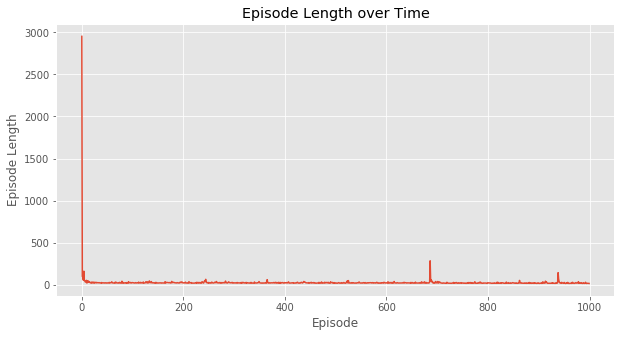

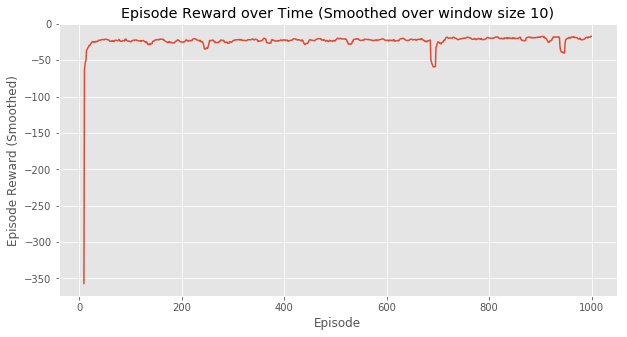

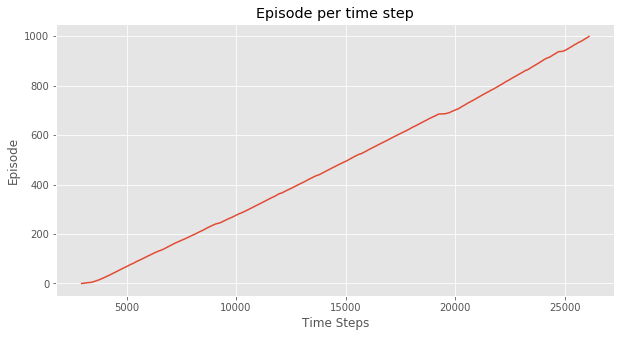

In [10]:
plot_episode_stats(episode_lengths, episode_rewards)

# Blackjack

In [11]:
envBlackJack = gym.make('Blackjack-v0')

PLAYER_STATE = 0
DEALER_STATE = 1
USABLE_ACE = 2

PLAYER_STATE_COUNT = envBlackJack.observation_space.spaces[PLAYER_STATE].n
DEALER_STATE_COUNT = envBlackJack.observation_space.spaces[DEALER_STATE].n
USABLE_ACE_COUNT = envBlackJack.observation_space.spaces[USABLE_ACE].n

ENVIRONMENT_SPACE = PLAYER_STATE_COUNT * DEALER_STATE_COUNT * USABLE_ACE_COUNT


def get_state_index(state):
    index = state[PLAYER_STATE] * (DEALER_STATE_COUNT * USABLE_ACE_COUNT)
    
    index += state[DEALER_STATE] * USABLE_ACE_COUNT
    
    if (state[USABLE_ACE] == True):
        index += 1
        
    return index

def test_bj_policy(env, policy, num_episodes=10000):
    rewards = 0
    for episode in range(num_episodes):
        done = False
        state = env.reset()
        while not done:
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            state, reward, done, _ = env.step(action)
        rewards += reward
    
    print (rewards)

correct_policy = np.ones([PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT]).astype(int)
correct_policy[12, 4:7, 0] = 0
correct_policy[13, 2:7, 0] = 0
correct_policy[14, 2:7, 0] = 0
correct_policy[15, 2:7, 0] = 0
correct_policy[16, 2:7, 0] = 0
correct_policy[17:22, :, 0] = 0
correct_policy[18, 2:9, 1] = 0
correct_policy[19:22, :, 1] = 0

## Monte Carlo

In [12]:
Q = monte_carlo(envBlackJack, num_episodes=100000, epsilon=0.1)

Episode 100000/100000.

In [13]:
learned_policy = np.zeros(ENVIRONMENT_SPACE).astype(int)

for state in Q:
    learned_policy[get_state_index(state)] = np.argmax(Q[state])
learned_policy = learned_policy.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)
error_rate = np.mean((np.bitwise_xor(learned_policy[4:22, :, :], correct_policy[4:22, :, :])))
print(error_rate)

0.3712121212121212


In [14]:
policy = make_greedy_policy(Q, envBlackJack.action_space.n)
test_bj_policy(envBlackJack, policy)

-514.0


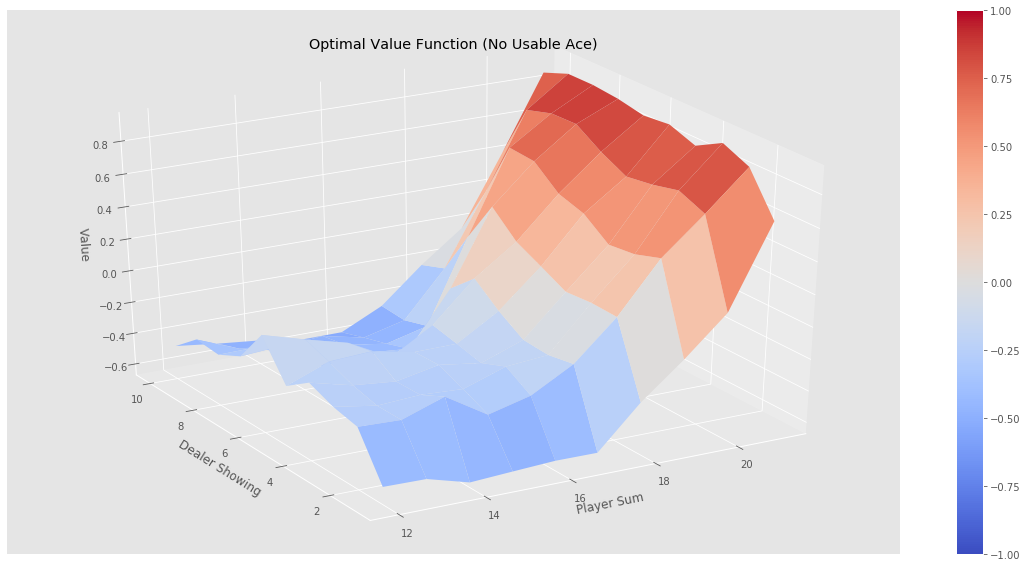

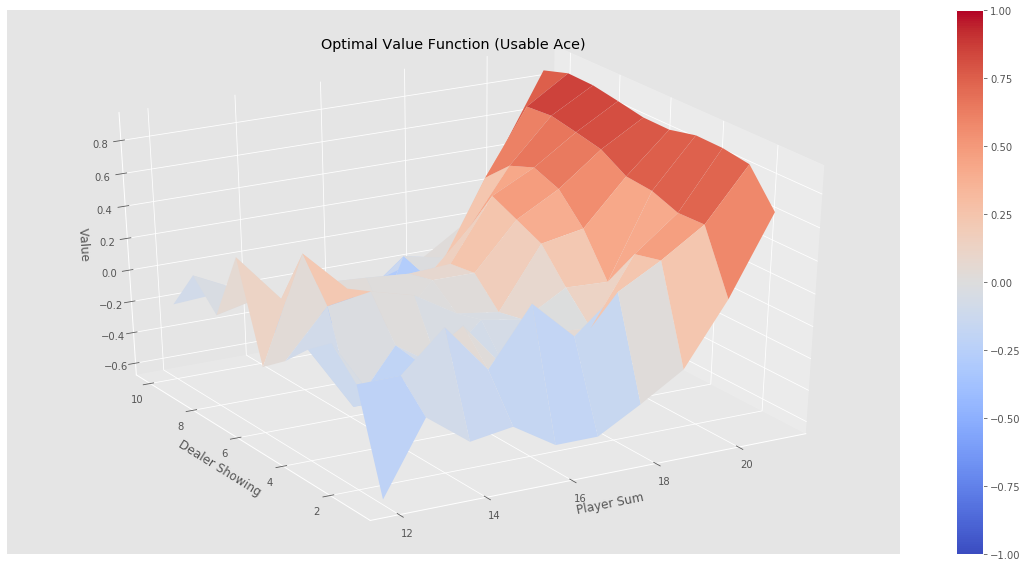

In [15]:
V = defaultdict(float)
for state, actions in Q.items():
    if (state[PLAYER_STATE] >= 12):
        action_value = np.max(actions)
        V[state] = action_value
plot_value_function(V, title="Optimal Value Function")

## Sarsa

In [16]:
Q, _, _, _ = sarsa(envBlackJack, 100000, gamma=1.0, lambdah = 0.9)   

Episode 100000/100000.

In [17]:
learned_policy = np.zeros(ENVIRONMENT_SPACE).astype(int)

for state in Q:
    learned_policy[get_state_index(state)] = np.argmax(Q[state])
learned_policy = learned_policy.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)
error_rate = np.mean((np.bitwise_xor(learned_policy[4:22, :, :], correct_policy[4:22, :, :])))
print(error_rate)

0.3383838383838384


In [18]:
policy = make_greedy_policy(Q, envBlackJack.action_space.n)
test_bj_policy(envBlackJack, policy)

-436.0


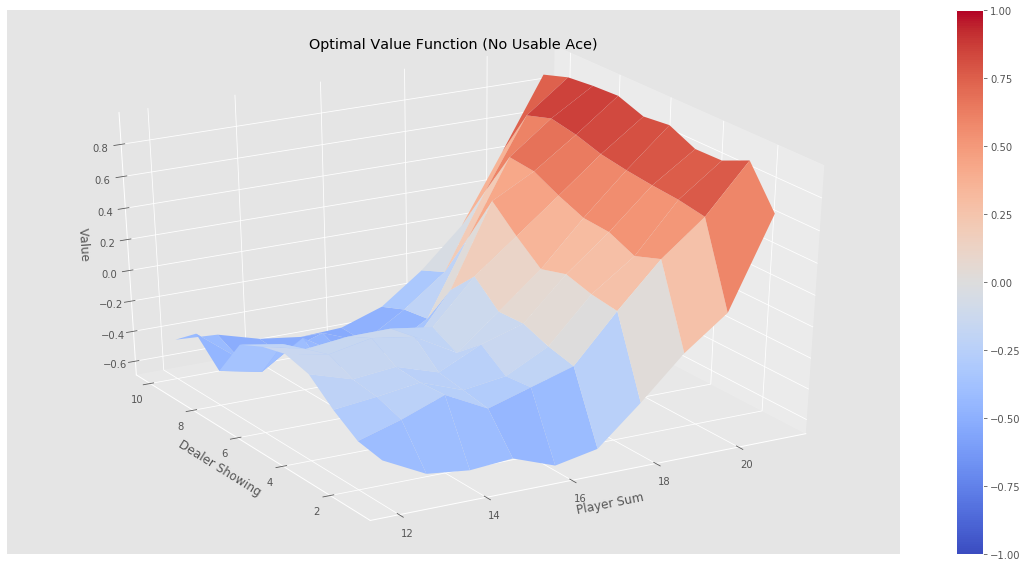

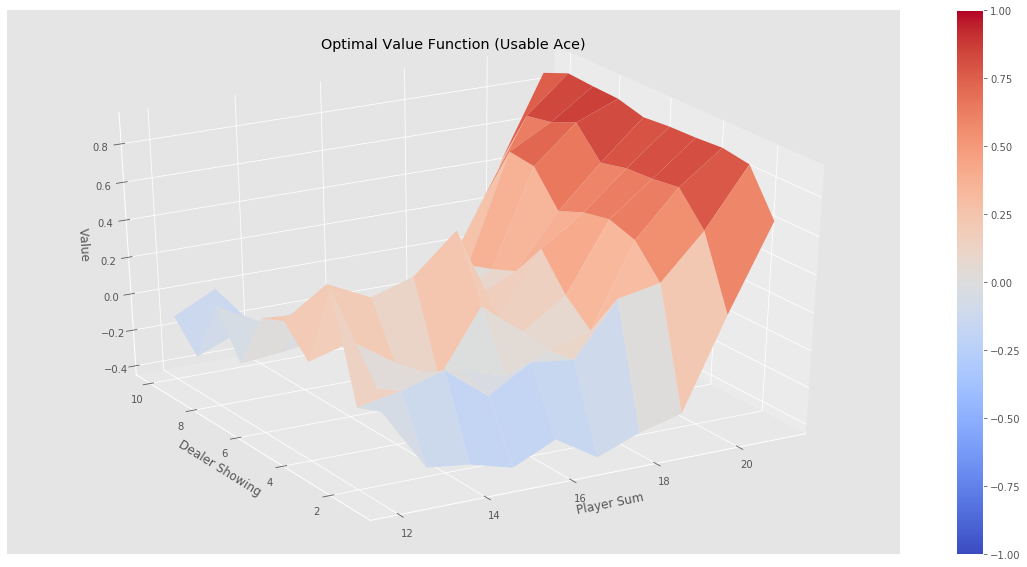

In [19]:
Vsarsa = defaultdict(float)
for state, actions in Q.items():
    if ((state[PLAYER_STATE] >= 12) and ((state[PLAYER_STATE] <= 21))):
        action_value = np.max(actions)
        Vsarsa[state] = action_value
plot_value_function(Vsarsa, title="Optimal Value Function")

# Cliff Walking

In [23]:
envCliff = gym.make('CliffWalking-v0')
Q, eligibility, episode_lengths, episode_rewards = sarsa(envCliff, 500, gamma=1.0, lambdah = 0.9, alpha=0.2)   

Episode 500/500.

In [24]:
policy = make_greedy_policy(Q, envCliff.action_space.n)
print(steps_to_complete_episode(envCliff, policy))

visualize_eligibility(eligibility, (4,12), (3,11))

18
[[0.   0.09 0.1  0.11 0.12 0.   0.19 0.21 0.23 0.84 0.94 1.04]
 [0.07 0.08 0.   0.   0.14 0.15 0.17 0.   0.   0.53 0.48 1.16]
 [0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.43 0.9 ]
 [0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


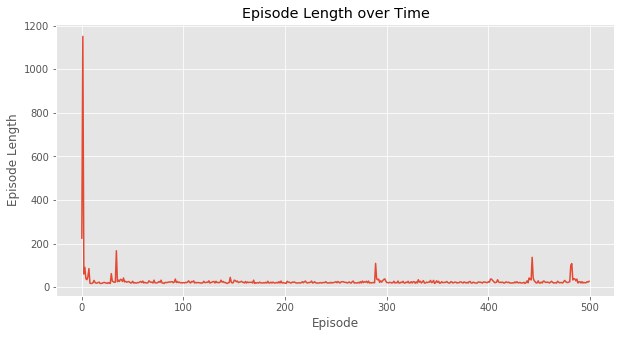

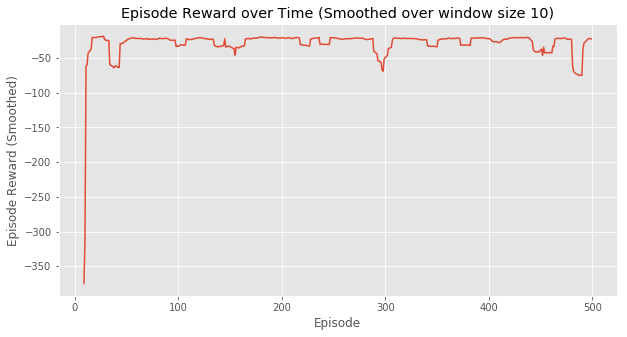

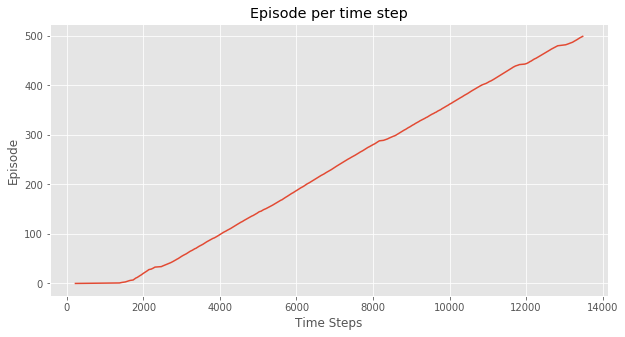

In [25]:
plot_episode_stats(episode_lengths, episode_rewards)